In [169]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.optimizers import SGD
from keras.models import Sequential,Model
from keras.layers import Conv1D,Embedding,MaxPooling1D,LSTM,Dropout,Dense,Bidirectional,Input,Flatten
from keras.initializers import Constant
from imblearn.over_sampling import SMOTE

In [2]:
with open('train.txt',encoding='utf-8') as f:
    train=f.read()

In [3]:
train_data=train.split('\n')

In [4]:
train_data[:5]

['i didnt feel humiliated;sadness',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake;sadness',
 'im grabbing a minute to post i feel greedy wrong;anger',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property;love',
 'i am feeling grouchy;anger']

In [5]:
def text_blob(text):
    return TextBlob(text).sentiment.polarity

In [6]:
train_labels=[text_blob(i) for i in train_data]

In [7]:
train_labels[:10]

[0.0,
 0.0,
 0.0,
 -0.5,
 0.0,
 0.00416666666666667,
 0.0,
 -0.15000000000000002,
 0.4000000000000001,
 0.0]

In [8]:
df_train=pd.DataFrame(data=train_data,columns=['text'])

In [9]:
df_train.head()

,text
0,i didnt feel humiliated;sadness
1,i can go from feeling so hopeless to so damned...
2,im grabbing a minute to post i feel greedy wro...
3,i am ever feeling nostalgic about the fireplac...
4,i am feeling grouchy;anger


In [10]:
df_train['label']=train_labels

In [11]:
df_train.head()

,text,label
0,i didnt feel humiliated;sadness,0.0
1,i can go from feeling so hopeless to so damned...,0.0
2,im grabbing a minute to post i feel greedy wro...,0.0
3,i am ever feeling nostalgic about the fireplac...,-0.5
4,i am feeling grouchy;anger,0.0


In [12]:
df_train[df_train['label']==0.0].shape

(4947, 2)

In [13]:
def label_q(num):
    if num<0.0:
        return 'Negative'
    elif num==0:
        return 'Nature'
    else:
        return 'Positive'

In [14]:
df_train['sentiment']=[label_q(i) for i in df_train['label']]

In [15]:
df_train.sample(5)

,text,label,sentiment
5318,im feeling pissed and sad right now;anger,-0.107143,Negative
1148,i think i brag and it feels strange because i ...,-0.059375,Negative
6343,i feel petrified about his future;fear,0.000000,Nature
8307,i thought i would challenge myself i really wa...,0.348611,Positive
13634,i am not feeling very clever or creative;joy,0.216667,Positive


In [16]:
df_train['sentiment'].value_counts()

sentiment
Positive    9174
Negative    5879
Nature      4947
Name: count, dtype: int64

In [17]:
df_nature=df_train[df_train['sentiment']=='Nature']
df_positive=df_train[df_train['sentiment']=='Positive']
df_negative=df_train[df_train['sentiment']=='Negative']

In [18]:
df_positive_n=df_positive.sample(df_nature.shape[0])
df_negative_n=df_negative.sample(df_nature.shape[0])

In [19]:
df_train_balanced=pd.concat([df_nature,df_positive_n,df_negative_n])

In [20]:
df_train_balanced.sample(5)

,text,label,sentiment
18979,i feel it is my sincere duty to rid you of tha...,0.500000,Positive
16484,i feel i was so innocent to have only one drea...,-0.033333,Negative
18141,im tired of feeling like damaged goods for bei...,-0.400000,Negative
3359,im warning you hes feeling cranky this morning...,0.000000,Nature
531,i just think about all the day i chatted with ...,0.000000,Nature


In [21]:
df_train_balanced['sentiment'].value_counts()

sentiment
Nature      4947
Positive    4947
Negative    4947
Name: count, dtype: int64

In [22]:
df_train_balanced.shape

(14841, 3)

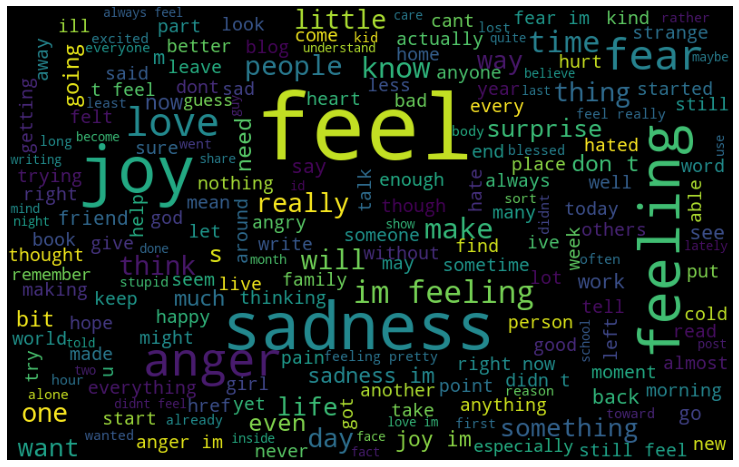

In [23]:
plt.figure(figsize=(13,15))
all_sen=' '.join(df_train_balanced['text'].tolist())
wordcloud_all=WordCloud(height=500,width=800,random_state=101,max_font_size=100).generate(all_sen)
plt.imshow(wordcloud_all)
plt.axis('off')
plt.show()

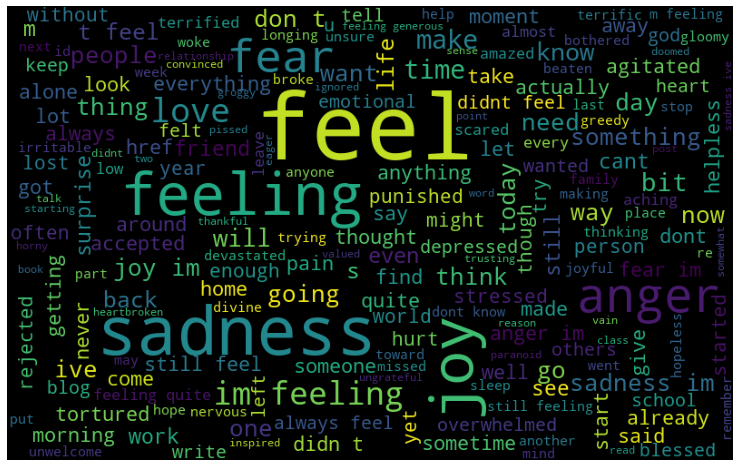

In [24]:
plt.figure(figsize=(13,15))
nature_sen=' '.join([sentence for sentence in df_train_balanced['text'][df_train_balanced['sentiment']=='Nature']])
wordcloud_nature=WordCloud(height=500,width=800,random_state=101,max_font_size=100).generate(nature_sen)
plt.imshow(wordcloud_nature)
plt.axis('off')
plt.show()

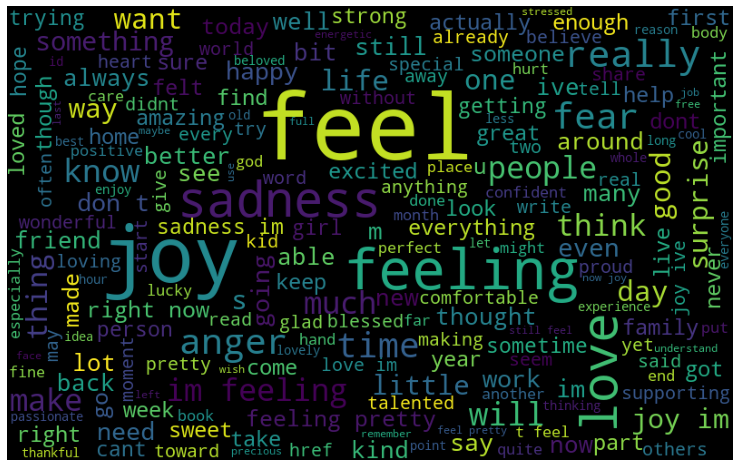

In [25]:
plt.figure(figsize=(13,15))
positive_sen=' '.join(df_train_balanced['text'][df_train_balanced['sentiment']=='Positive'].tolist())
wordcloud_positive=WordCloud(height=500,width=800,random_state=101,max_font_size=100).generate(positive_sen)
plt.imshow(wordcloud_positive)
plt.axis('off')
plt.show()

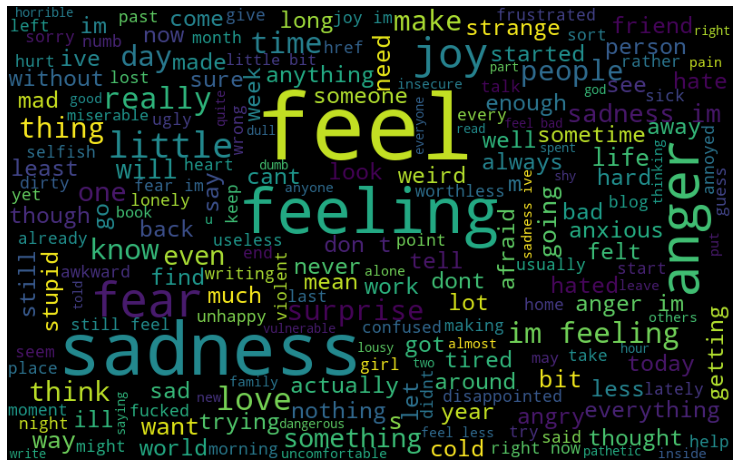

In [26]:
plt.figure(figsize=(13,15))
negative_sen=' '.join([sentence for sentence in df_train_balanced['text'][df_train_balanced['sentiment']=='Negative']])
wordcloud_negative=WordCloud(height=500,width=800,random_state=101,max_font_size=100).generate(negative_sen)
plt.imshow(wordcloud_negative)
plt.axis('off')
plt.show()

In [27]:
df_train_balanced['labels_num']=df_train_balanced['sentiment'].map({
    'Negative':0,
    'Nature':1,
    'Positive':2
})

In [28]:
df_train_balanced.sample(5)

,text,label,sentiment,labels_num
4098,i have been feeling generally disheartened by ...,0.0500,Positive,2
15502,i feel for the tender teenager who i fear may ...,0.0250,Positive,2
17617,i kinda get real attached and excited when i f...,0.2875,Positive,2
17383,this monday i took a math bs test and flunked ...,0.0000,Nature,1
1177,i feel awful and have had chills on and off da...,-1.0000,Negative,0


In [29]:
sw=stopwords.words('english')

In [30]:
lemmatizer=WordNetLemmatizer()

In [31]:
def text_preprocessing(text):
    text=text.lower()
    text=re.sub('[^a-z]',' ',text)
    text=re.sub('\s+[a-z]\s+',' ',text)
    text=re.sub('\s+',' ',text)
    words=[word for word in text.split() if word not in sw]
    words=[lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [32]:
df_train_balanced['pre_text']=df_train_balanced['text'].apply(text_preprocessing)

In [33]:
df_train_balanced.sample(5)

,text,label,sentiment,labels_num,pre_text
12134,i think there are quality submissions out ther...,0.5,Positive,2,think quality submission author conforming wri...
3559,i have a lovely nesty feeling after looking at...,0.5,Positive,2,lovely nesty feeling looking cute teeny weeny ...
18979,i feel it is my sincere duty to rid you of tha...,0.5,Positive,2,feel sincere duty rid house god scared built joy
8841,i woke up feeling this aching in my heart;sadness,0.0,Nature,1,woke feeling aching heart sadness
5772,i didn t even feel cranky about it;anger,0.0,Nature,1,even feel cranky anger


In [34]:
X_train,X_test,y_train,y_test=train_test_split(df_train_balanced['pre_text'],df_train_balanced['labels_num'],test_size=0.2,
                                              random_state=101,stratify=df_train_balanced['labels_num'],shuffle=True)

In [35]:
X_train.shape

(11872,)

In [36]:
X_test.shape

(2969,)

In [37]:
y_train.value_counts()

labels_num
2    3958
1    3957
0    3957
Name: count, dtype: int64

In [38]:
y_test.value_counts()

labels_num
1    990
0    990
2    989
Name: count, dtype: int64

In [39]:
clf=Pipeline([
    ('cv',CountVectorizer(ngram_range=(1,3))),
    ('rf',RandomForestClassifier())
])

In [40]:
clf.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 3))),
                ('rf', RandomForestClassifier())])

In [41]:
y_pred=clf.predict(X_test)

In [42]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.56      0.67       990
           1       0.59      0.90      0.71       990
           2       0.79      0.62      0.69       989

    accuracy                           0.69      2969
   macro avg       0.73      0.69      0.69      2969
weighted avg       0.73      0.69      0.69      2969



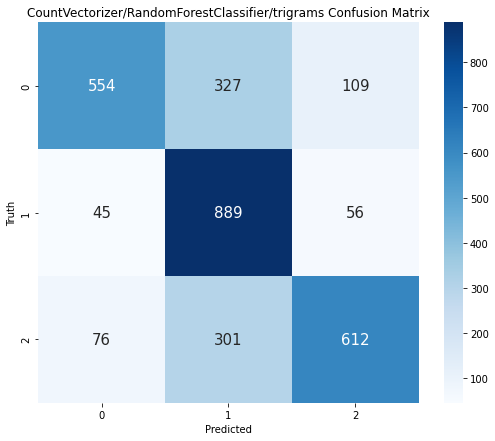

In [43]:
plt.figure(figsize=(9,7))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,square=True,cbar=True,annot_kws={'size':15},fmt='d',cmap='Blues')
plt.title('CountVectorizer/RandomForestClassifier/trigrams Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [44]:
clf2=Pipeline([
    ('cv',CountVectorizer(ngram_range=(1,2))),
    ('nb',MultinomialNB())
])

In [45]:
clf2.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 2))),
                ('nb', MultinomialNB())])

In [46]:
y_pred2=clf2.predict(X_test)

In [47]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.66      0.76      0.71       990
           1       0.78      0.54      0.64       990
           2       0.66      0.76      0.71       989

    accuracy                           0.69      2969
   macro avg       0.70      0.69      0.68      2969
weighted avg       0.70      0.69      0.68      2969



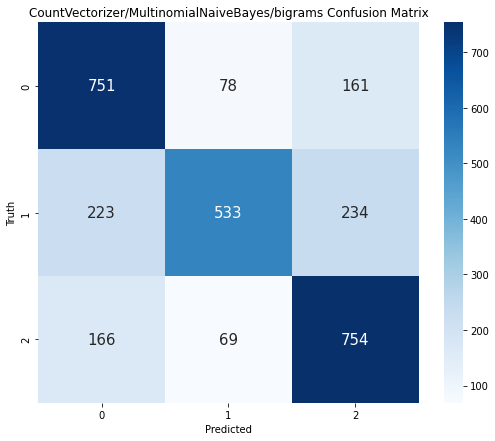

In [48]:
plt.figure(figsize=(9,7))
sns.heatmap(confusion_matrix(y_test,y_pred2),annot=True,square=True,cbar=True,annot_kws={'size':15},fmt='d',cmap='Blues')
plt.title('CountVectorizer/MultinomialNaiveBayes/bigrams Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [49]:
clf3=Pipeline([
    ('cv',CountVectorizer(ngram_range=(1,1))),
    ('nb',MultinomialNB())
])

In [50]:
clf3.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('nb', MultinomialNB())])

In [51]:
y_pred3=clf3.predict(X_test)

In [52]:
print(classification_report(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.68      0.76      0.72       990
           1       0.77      0.58      0.66       990
           2       0.66      0.75      0.71       989

    accuracy                           0.70      2969
   macro avg       0.70      0.70      0.70      2969
weighted avg       0.70      0.70      0.70      2969



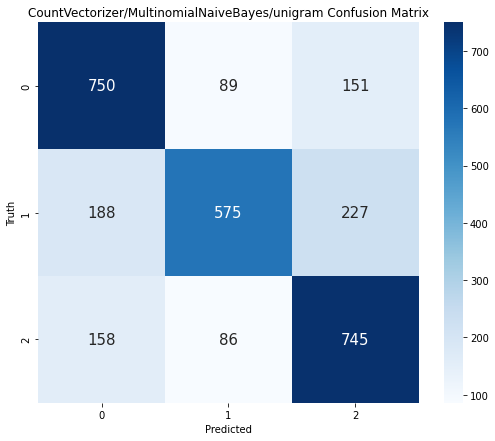

In [53]:
plt.figure(figsize=(9,7))
sns.heatmap(confusion_matrix(y_test,y_pred3),annot=True,square=True,cbar=True,annot_kws={'size':15},fmt='d',cmap='Blues')
plt.title('CountVectorizer/MultinomialNaiveBayes/unigram Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [54]:
clf4=Pipeline([
    ('cv',CountVectorizer(ngram_range=(1,2))),
    ('rf',RandomForestClassifier())
])

In [55]:
clf4.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 2))),
                ('rf', RandomForestClassifier())])

In [56]:
y_pred4=clf4.predict(X_test)

In [57]:
print(classification_report(y_test,y_pred4))

              precision    recall  f1-score   support

           0       0.81      0.59      0.68       990
           1       0.62      0.87      0.72       990
           2       0.77      0.66      0.71       989

    accuracy                           0.71      2969
   macro avg       0.73      0.71      0.71      2969
weighted avg       0.73      0.71      0.71      2969



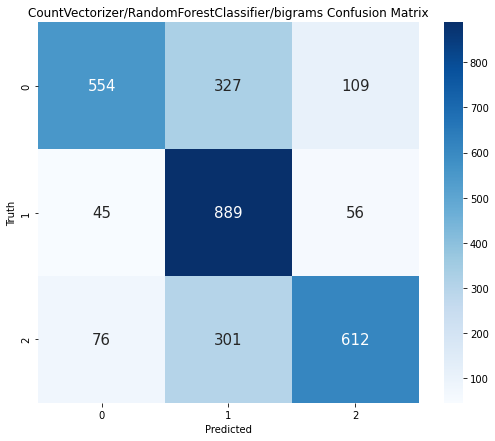

In [58]:
plt.figure(figsize=(9,7))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,square=True,cbar=True,annot_kws={'size':15},fmt='d',cmap='Blues')
plt.title('CountVectorizer/RandomForestClassifier/bigrams Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [59]:
clf5=Pipeline([
    ('cv',CountVectorizer(ngram_range=(1,1))),
    ('rf',RandomForestClassifier())
])

In [60]:
clf5.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('rf', RandomForestClassifier())])

In [61]:
y_pred5=clf5.predict(X_test)

In [62]:
print(classification_report(y_test,y_pred5))

              precision    recall  f1-score   support

           0       0.79      0.61      0.69       990
           1       0.63      0.85      0.72       990
           2       0.75      0.66      0.70       989

    accuracy                           0.70      2969
   macro avg       0.72      0.70      0.70      2969
weighted avg       0.72      0.70      0.70      2969



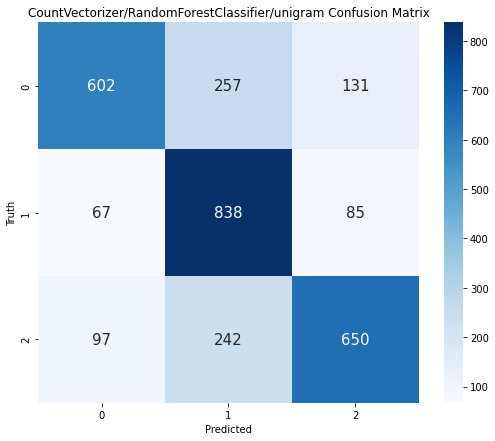

In [63]:
plt.figure(figsize=(9,7))
sns.heatmap(confusion_matrix(y_test,y_pred5),annot=True,square=True,cbar=True,annot_kws={'size':15},fmt='d',cmap='Blues')
plt.title('CountVectorizer/RandomForestClassifier/unigram Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [64]:
clf6=Pipeline([
    ('tfidf_vectorizer',TfidfVectorizer()),
    ('rf',RandomForestClassifier())
])

In [65]:
clf6.fit(X_train,y_train)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('rf', RandomForestClassifier())])

In [66]:
y_pred6=clf6.predict(X_test)

In [67]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.56      0.67       990
           1       0.59      0.90      0.71       990
           2       0.79      0.62      0.69       989

    accuracy                           0.69      2969
   macro avg       0.73      0.69      0.69      2969
weighted avg       0.73      0.69      0.69      2969



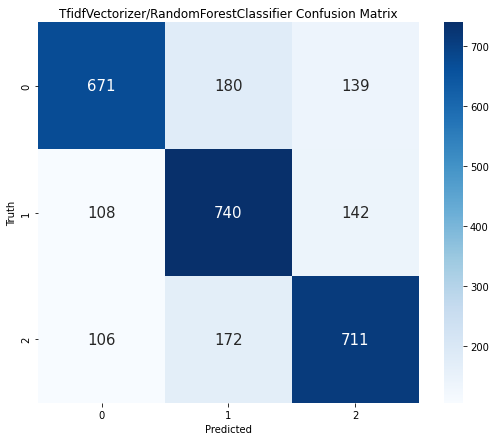

In [68]:
plt.figure(figsize=(9,7))
sns.heatmap(confusion_matrix(y_test,y_pred6),annot=True,square=True,cbar=True,annot_kws={'size':15},fmt='d',cmap='Blues')
plt.title('TfidfVectorizer/RandomForestClassifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [69]:
clf7=Pipeline([
    ('tfidf_vectorizer',TfidfVectorizer()),
    ('nb',MultinomialNB())
])

In [70]:
clf7.fit(X_train,y_train)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('nb', MultinomialNB())])

In [71]:
y_pred7=clf7.predict(X_test)

In [72]:
print(classification_report(y_test,y_pred7))

              precision    recall  f1-score   support

           0       0.71      0.74      0.72       990
           1       0.74      0.60      0.66       990
           2       0.67      0.76      0.71       989

    accuracy                           0.70      2969
   macro avg       0.70      0.70      0.70      2969
weighted avg       0.70      0.70      0.70      2969



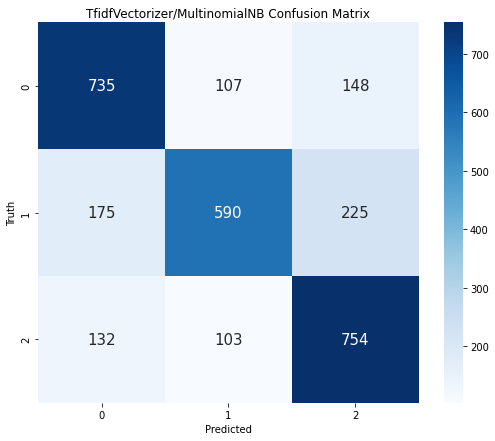

In [73]:
plt.figure(figsize=(9,7))
sns.heatmap(confusion_matrix(y_test,y_pred7),annot=True,square=True,cbar=True,annot_kws={'size':15},fmt='d',cmap='Blues')
plt.title('TfidfVectorizer/MultinomialNB Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [153]:
df_train

,text,label,sentiment
0,i didnt feel humiliated;sadness,0.0,Nature
1,i can go from feeling so hopeless to so damned...,0.0,Nature
2,im grabbing a minute to post i feel greedy wro...,0.0,Nature
3,i am ever feeling nostalgic about the fireplac...,-0.5,Negative
4,i am feeling grouchy;anger,0.0,Nature
...,...,...,...
19995,im having ssa examination tomorrow in the morn...,0.1,Positive
19996,i constantly worry about their fight against n...,0.0,Nature
19997,i feel its important to share this info for th...,0.2,Positive
19998,i truly feel that if you are passionate enough...,0.1,Positive


In [154]:
df_train['labelnum']=df_train['sentiment'].map({
    'Negative':0,
    'Nature':1,
    'Positive':2
})

In [155]:
df_train['labelnum'].value_counts()

labelnum
2    9174
0    5879
1    4947
Name: count, dtype: int64

In [156]:
df_train['text_pre']=df_train['text'].apply(text_preprocessing)

In [158]:
df_train.head()

,text,label,sentiment,labelnum,text_pre
0,i didnt feel humiliated;sadness,0.0,Nature,1,didnt feel humiliated sadness
1,i can go from feeling so hopeless to so damned...,0.0,Nature,1,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wro...,0.0,Nature,1,im grabbing minute post feel greedy wrong anger
3,i am ever feeling nostalgic about the fireplac...,-0.5,Negative,0,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy;anger,0.0,Nature,1,feeling grouchy anger


In [159]:
v=TfidfVectorizer()

In [161]:
X=v.fit_transform(df_train['text_pre'])

In [162]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [164]:
len(X.toarray())

20000

In [166]:
y=df_train['labelnum']

In [167]:
len(y)

20000

In [168]:
y.value_counts()

labelnum
2    9174
0    5879
1    4947
Name: count, dtype: int64

In [173]:
smote=SMOTE(sampling_strategy='minority')

In [174]:
X_sm,y_sm=smote.fit_resample(X,y)

In [175]:
y_sm.value_counts()

labelnum
1    9174
2    9174
0    5879
Name: count, dtype: int64

In [176]:
X_ssm,y_ssm=smote.fit_resample(X_sm,y_sm)

In [177]:
y_ssm.value_counts()

labelnum
1    9174
0    9174
2    9174
Name: count, dtype: int64

In [178]:
X_tr,X_te,y_tr,y_te=train_test_split(X_ssm,y_ssm,test_size=0.2,random_state=101,stratify=y_ssm,shuffle=True)

In [179]:
X_tr.shape

(22017, 15083)

In [184]:
X_te.shape

(5505, 15083)

In [183]:
X_ssm.shape

(27522, 15083)

In [187]:
nb=MultinomialNB()

In [188]:
nb.fit(X_tr,y_tr)

MultinomialNB()

In [189]:
y_p=nb.predict(X_te)

In [190]:
print(classification_report(y_te,y_p))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80      1835
           1       0.82      0.73      0.77      1835
           2       0.75      0.75      0.75      1835

    accuracy                           0.78      5505
   macro avg       0.78      0.78      0.77      5505
weighted avg       0.78      0.78      0.77      5505



In [191]:
rf=RandomForestClassifier()

In [192]:
rf.fit(X_tr,y_tr)

RandomForestClassifier()

In [193]:
y_p2=rf.predict(X_te)

In [194]:
print(classification_report(y_te,y_p2))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1835
           1       0.81      0.86      0.83      1835
           2       0.80      0.78      0.79      1835

    accuracy                           0.82      5505
   macro avg       0.82      0.82      0.82      5505
weighted avg       0.82      0.82      0.82      5505



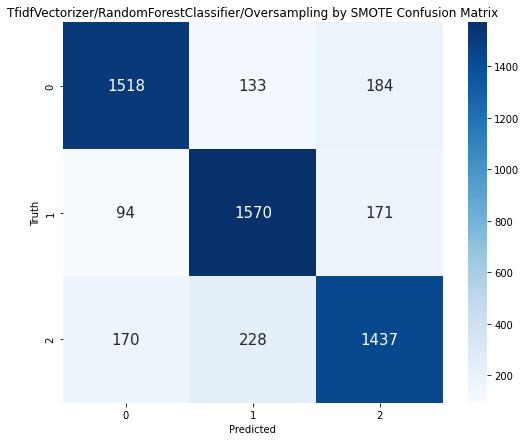

In [203]:
plt.figure(figsize=(9,7))
sns.heatmap(confusion_matrix(y_te,y_p2,),annot=True,square=True,cbar=True,annot_kws={'size':15},fmt='d',cmap='Blues')
plt.title('TfidfVectorizer/RandomForestClassifier/Oversampling by SMOTE Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()